# Required Dependencies

In [1]:
import pandas as pd
from surprise import Dataset
from surprise import Reader
import matplotlib.pyplot as plt
import numpy as np
import math
from wordcloud import WordCloud
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import warnings
import random

# Exploratory Data Analysis

In [2]:
# loading the datasets 
ratings_1m=pd.read_csv("ml-1m/ratings.dat", sep='::',header=None, engine='python')
ratings_1m=ratings_1m.rename(columns={0: "UserID", 1: "MovieID", 2: "Rating", 3: "Timestamp"})
movies_1m=pd.read_csv("ml-1m/movies.dat", sep='::',header=None, engine='python')
movies_1m=movies_1m.rename(columns={0: "MovieID", 1: "Title", 2: "Genres"})
users_1m=pd.read_csv("ml-1m/users.dat", sep='::',header=None, engine='python')
users_1m=users_1m.rename(columns={0: "UserID", 1: "Gender", 2: "Age", 3: "Occupation", 4: "Zip-code"})

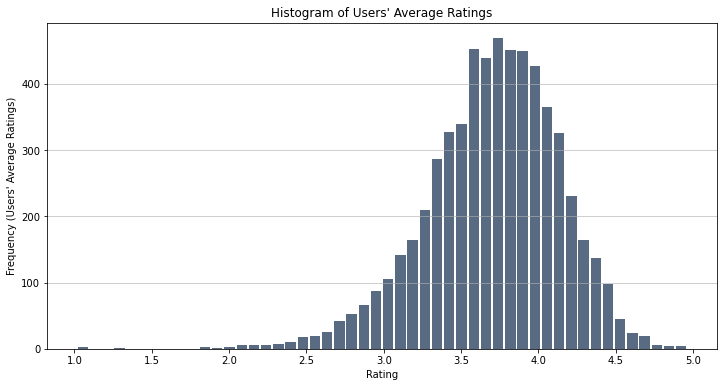

In [3]:
# plot of users' average rating 
plt.hist(ratings_1m.groupby('UserID')['Rating'].mean().tolist(),bins=50, color='#112D4E',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Rating')
plt.ylabel('Frequency (Users\' Average Ratings)')
plt.title('Histogram of Users\' Average Ratings')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('users_average_rating .png', dpi=100)
plt.show()

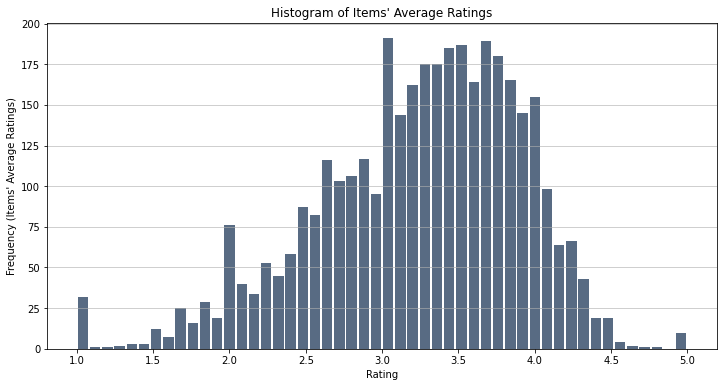

In [4]:
# plot of items' average rating 
plt.hist(ratings_1m.groupby('MovieID')['Rating'].mean().tolist(),bins=50, color='#112D4E',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Rating')
plt.ylabel('Frequency (Items\' Average Ratings)')
plt.title('Histogram of Items\' Average Ratings')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('items_average_rating.png', dpi=100)
plt.show()

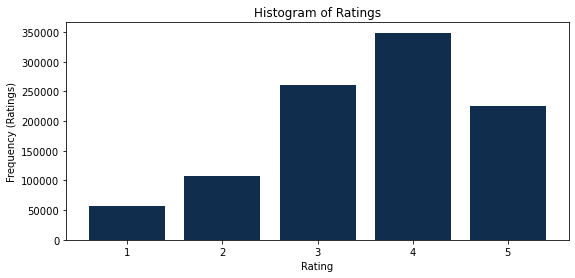

In [5]:
# plot of ratings
plt.bar(sorted(ratings_1m.Rating.unique()),ratings_1m.groupby('Rating')['UserID'].count(), color='#112D4E')
plt.xlabel('Rating')
plt.ylabel('Frequency (Ratings)')
plt.title('Histogram of Ratings')
fig = plt.gcf()
fig.set_size_inches(9, 4)
fig.savefig('ratings.png', dpi=100)
plt.show()

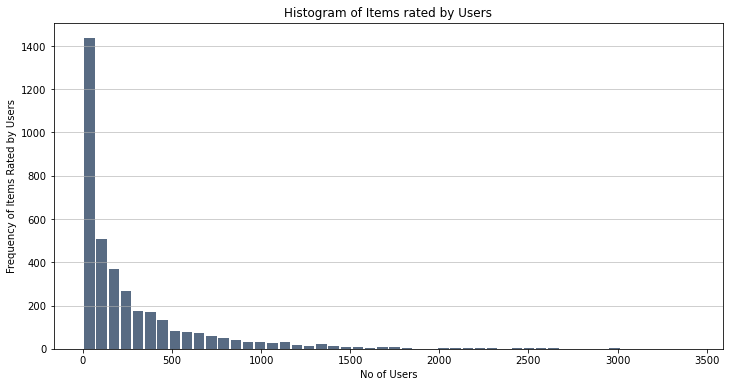

In [6]:
# plot of histogram of items\' rated by users
plt.hist(ratings_1m.groupby('MovieID')['UserID'].count().tolist(),bins=50, color='#112D4E',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('No of Users')
plt.ylabel('Frequency of Items Rated by Users')
plt.title('Histogram of Items rated by Users')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('items_rated_by_users.png', dpi=100)
plt.show()

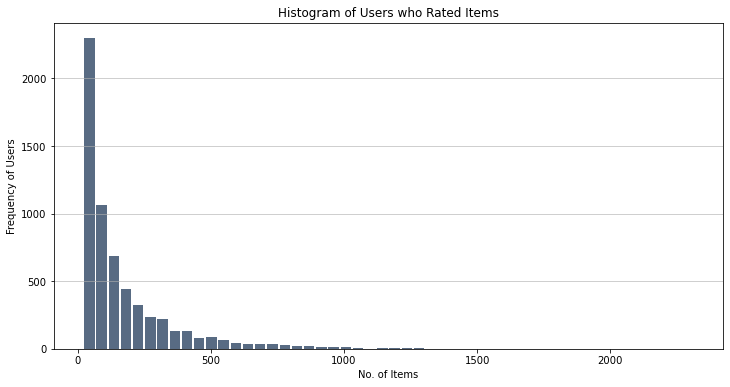

In [7]:
# plot of items rated by users
plt.hist(ratings_1m.groupby('UserID')['MovieID'].count().tolist(),bins=50, color='#112D4E',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('No. of Items')
plt.ylabel('Frequency of Users')
plt.title('Histogram of Users who Rated Items')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('users_who_rated_items.png', dpi=100)
plt.show()

### Wordcloud shows us which genres are most prominent ones among the movies.

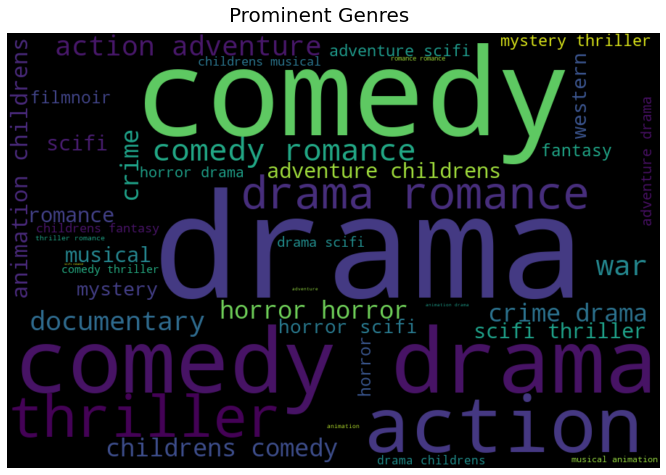

In [8]:
# wordcloud of genres to show prominent genres

x=movies_1m['Genres'].values.tolist()

all_genres=""
for line in x:
    words=str(line).split("|") #sometimes there were error: 'float' object has no attribute 'split'. That's why cast as a string. 
    for word in words:
        word=word.translate(str.maketrans('', '', string.punctuation))
        word=word.lower()
        all_genres=str(all_genres)+" "+str(word)

wordcloud = WordCloud(max_font_size=200, width=900, height=600,collocations=True).generate(all_genres)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.figtext(.5,.9,"Prominent Genres", fontsize=20, ha='center')
fig = plt.gcf()
fig.savefig('wordcloud.png', dpi=100)
plt.show()

In [9]:
temp = movies_1m['Genres'].values.tolist()
temp = list(set(temp))
temp

['Drama|Thriller',
 'Action|Romance',
 "Animation|Children's|Comedy|Musical",
 'War',
 'Action|Comedy',
 "Adventure|Children's|Comedy|Fantasy|Sci-Fi",
 'Drama|Mystery|Sci-Fi|Thriller',
 'Crime|Film-Noir|Mystery',
 'Drama',
 'Action|Mystery|Thriller',
 'Musical',
 'Comedy|Documentary',
 'Comedy|Mystery|Romance',
 'Comedy|Crime|Thriller',
 'Drama|Musical',
 'Comedy|Film-Noir|Thriller',
 'Action|Drama|Fantasy|Romance',
 'Action|Adventure|Crime|Thriller',
 "Adventure|Animation|Children's|Musical",
 'Animation|Comedy',
 'Action|Crime|Mystery|Thriller',
 'Action|Adventure|Mystery',
 'Romance',
 'Action|Romance|Sci-Fi',
 "Action|Children's",
 'Action|Sci-Fi|War',
 "Children's|Fantasy|Sci-Fi",
 'Sci-Fi|Thriller',
 'Action|Drama|Romance|Thriller',
 'Action|Crime|Drama',
 'Mystery|Romance|Thriller',
 'Comedy|Drama|Musical',
 'Adventure|Drama|Romance',
 'Drama|Sci-Fi',
 "Adventure|Children's|Comedy|Fantasy",
 'Comedy|Romance|War',
 'Action|Adventure',
 'Crime|Thriller',
 'Crime|Drama|Romance',
 '

In [10]:
uniqueGenres = [ 'Action', 'Adventure', 'Fantasy', 'Sci-Fi', 'Animation', 'Horror', 'Drama', 'Mystery', 'Romance', 'Comedy', 'Crime', 'Musical', 'War', "Children\'s", 'Thriller', 'Western', 'Documentary', 'Film-Noir']
uniqueGenres.sort()
uniqueGenres

['Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

# Collaborative Filtering Based Recommendation System

In [11]:
# collaborative filtering using suprise with SVD algorithm

from surprise import Reader, Dataset
from surprise import SVD
from surprise.model_selection import cross_validate

reader = Reader()
data = Dataset.load_from_df(ratings_1m[["UserID", "MovieID", "Rating"]], reader)

# use SDV algorithm
algo = SVD()

# run 5-fold cross-validation
x=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8757  0.8747  0.8740  0.8734  0.8717  0.8739  0.0013  
MAE (testset)     0.6877  0.6857  0.6861  0.6857  0.6846  0.6859  0.0010  
Fit time          232.71  214.19  206.84  218.82  221.36  218.78  8.53    
Test time         17.92   12.03   10.86   13.16   10.47   12.89   2.69    


### We can see the plot of RMSE & MAE for collaborative filter on 5 fold test set. 

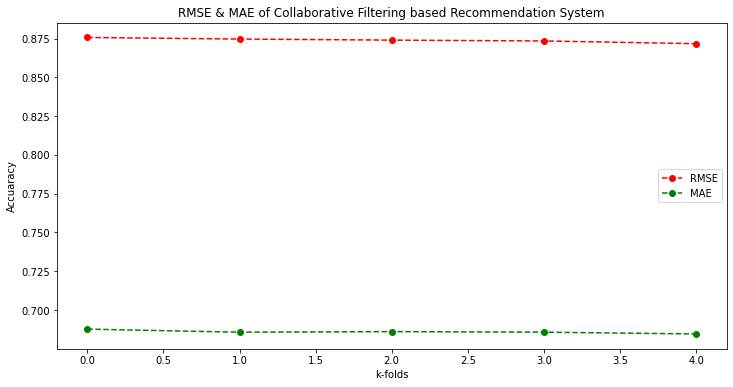

In [12]:
plt.plot(x['test_rmse'], 'ro--', label='RMSE')
plt.plot(x['test_mae'], 'go--', label='MAE')
plt.xlabel('k-folds')
plt.ylabel('Accuaracy')
plt.legend()
plt.title('RMSE & MAE of Collaborative Filtering based Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('cf_rmse_mae.png', dpi=100)
plt.show()

### Getting top 20 recommendation for a particular user

In [13]:
# get top 20 recommendation for a user
titles = movies_1m['Title']
indices = pd.Series(movies_1m.index, index=movies_1m['Title'])

# function that get movie recommendations based on the cosine similarity score of movie genres
def cf_top_reco(userId):
    cf_df=pd.DataFrame()\
    
    movie_id_list=ratings_1m['MovieID'].unique().tolist()
    est=[]
    movie_name_list=[]
    actual_score_list=[]
    genre_list=[]
    for i in movie_id_list:
        pred = algo.predict(userId, i, verbose=False)
        est.append(pred[3])
        movie_name = movies_1m[movies_1m.MovieID==i]['Title'].values
        movie_name_list.append(movie_name)
        actual_score =  ratings_1m[(ratings_1m.MovieID==i)&(ratings_1m.UserID==userId)]['Rating'].values
        actual_score_list.append(actual_score)
        genre = movies_1m[movies_1m.MovieID==i]['Genres'].values
        try:
            genre_list.append(genre)
        except:
            genre_list.append('Unavailable')      
    cf_df['movie_id']=movie_id_list
    cf_df['estimated_rating']=est
    cf_df['title']=movie_name_list
    cf_df['actual_rating']=actual_score_list
    cf_df['genres']=genre_list
    cf_df=cf_df.sort_values(['estimated_rating'], ascending=[False])
    return cf_df

### Here we see that collaborative filtering can tell us the movies that a user is likely to rate higher. But it has no way of recommending similar movies to a particular one tailored for the specific user. The genres here are all over the place.

In [14]:
# the function takes userid as input & generates top 20 recommendation for that user. In Actual Rating field we don't 
# have all values populated. This is becasue not all users rated all movies. 
userid=2
cf_top_reco(userid).head(10)

,movie_id,estimated_rating,title,actual_rating,genres
164,1784,4.619141,[As Good As It Gets (1997)],[5],[Comedy|Drama]
59,2268,4.562343,"[Few Good Men, A (1992)]",[5],[Crime|Drama]
1651,1172,4.489401,[Cinema Paradiso (1988)],[],[Comedy|Drama|Romance]
149,2501,4.466916,[October Sky (1999)],[5],[Drama]
23,527,4.462177,[Schindler's List (1993)],[],[Drama|War]
1449,922,4.451677,[Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)],[],[Film-Noir]
174,1247,4.440455,"[Graduate, The (1967)]",[5],[Drama|Romance]
1092,2019,4.436442,[Seven Samurai (The Magnificent Seven) (Shichi...,[],[Action|Drama]
2702,2351,4.433733,[Nights of Cabiria (Le Notti di Cabiria) (1957)],[],[Drama]
167,318,4.409463,"[Shawshank Redemption, The (1994)]",[5],[Drama]


# Content Based Recommendation System

In [15]:
# break up the big genre string into a string array
movies_1m['Genres'] = movies_1m['Genres'].str.split('|')
# convert genres to string value
movies_1m['Genres'] = movies_1m['Genres'].fillna("").astype('str')

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies_1m['Genres'])
df = pd.DataFrame(tfidf_matrix.toarray(), columns = tf.get_feature_names())
#print(df)
#tfidf_matrix.shape



In [17]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:5, :5]

array([[1.        , 0.14193614, 0.09010857, 0.1056164 , 0.23523322],
       [0.14193614, 1.        , 0.        , 0.        , 0.        ],
       [0.09010857, 0.        , 1.        , 0.1719888 , 0.38306058],
       [0.1056164 , 0.        , 0.1719888 , 1.        , 0.4489859 ],
       [0.23523322, 0.        , 0.38306058, 0.4489859 , 1.        ]])

In [18]:
# build an 1-dimensional array with movie titles
titles = movies_1m['Title']
movie_id = movies_1m['MovieID']
indices = pd.Series(movies_1m.index, index=movies_1m['Title'])

# function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     print(sim_scores)
    sim_scores = sim_scores[1:]
    movie_indices = [i[0] for i in sim_scores]
    cb_df=pd.DataFrame(sim_scores)
    cb_df['title']=titles.iloc[movie_indices].values
    cb_df['movie_id']=movie_id.iloc[movie_indices].values
    cb_df=cb_df.rename(columns={0: "movie_index", 1: "similarity_score"})
    genre_list=[]
    for i in cb_df['movie_id'].values:
        genre = movies_1m[movies_1m.MovieID==i]['Genres'].values
        try:
            genre_list.append(genre)
        except:
            genre_list.append('Unavailable') 
    cb_df['genres']=genre_list
    return cb_df

### While content based has the option to find us the most similar movies to a given one, it has no intution into whether a user will like it or not. 

In [19]:
movies_1m[movies_1m.Title=='Chicken Run (2000)']

,MovieID,Title,Genres
3682,3751,Chicken Run (2000),"['Animation', ""Children's"", 'Comedy']"


In [20]:
title='Chicken Run (2000)'
genre_recommendations(title).head(10)

,movie_index,similarity_score,title,movie_id,genres
0,1050,1.000000,Aladdin and the King of Thieves (1996),1064,"[['Animation', ""Children's"", 'Comedy']]"
1,2072,1.000000,"American Tail, An (1986)",2141,"[['Animation', ""Children's"", 'Comedy']]"
2,2073,1.000000,"American Tail: Fievel Goes West, An (1991)",2142,"[['Animation', ""Children's"", 'Comedy']]"
3,2285,1.000000,"Rugrats Movie, The (1998)",2354,"[['Animation', ""Children's"", 'Comedy']]"
4,2286,1.000000,"Bug's Life, A (1998)",2355,"[['Animation', ""Children's"", 'Comedy']]"
5,3045,1.000000,Toy Story 2 (1999),3114,"[['Animation', ""Children's"", 'Comedy']]"
6,3542,1.000000,Saludos Amigos (1943),3611,"[['Animation', ""Children's"", 'Comedy']]"
7,3682,1.000000,Chicken Run (2000),3751,"[['Animation', ""Children's"", 'Comedy']]"
8,3685,1.000000,"Adventures of Rocky and Bullwinkle, The (2000)",3754,"[['Animation', ""Children's"", 'Comedy']]"
9,236,0.869805,"Goofy Movie, A (1995)",239,"[['Animation', ""Children's"", 'Comedy', 'Romanc..."


# Hybrid Recommendation System

In [21]:
# an 1-dimensional array with movie titles
titles = movies_1m['Title']
movie_id = movies_1m['MovieID']
indices = pd.Series(movies_1m.index, index=movies_1m['Title'])

# function that get movie recommendations based on the cosine similarity score of movie genres and estimate the rating 
# given the particular user

def hybrid_recommendations(userId,title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:100]
    movie_indices = [i[0] for i in sim_scores]
    hybrid_df=pd.DataFrame(sim_scores)
    hybrid_df['title']=titles.iloc[movie_indices].values
    
    hybrid_df['movie_id']=movie_id.iloc[movie_indices].values
    
    est=[]
    actual_score_list=[]
    hybrid_df=hybrid_df.rename(columns={0: "movie_index", 1: "similarity_score"})
    for i in movie_indices:
        pred = algo.predict(userId, i, verbose=False)
        est.append(pred[3])
        actual_score =  ratings_1m[(ratings_1m.MovieID==i)&(ratings_1m.UserID==userId)]['Rating'].values
        actual_score_list.append(actual_score)
    hybrid_df['estimated_rating']=est
    hybrid_df['actual_rating']=actual_score_list
    
    genre_list=[]
    for i in hybrid_df['movie_id'].values:
        genre = movies_1m[movies_1m.MovieID==i]['Genres'].values
        try:
            genre_list.append(genre)
        except:
            genre_list.append('Unavailable') 
    hybrid_df['genres']=genre_list
    
    hybrid_df=hybrid_df.sort_values(['similarity_score','estimated_rating'], ascending=[False,False])
    return hybrid_df

### A hybrid system gives us the best of both worlds. It can recommend similar movies to a particular one that the user is most likely to rate high. 

In [22]:
userid=1
title='Chicken Run (2000)'
recommendationsFromHybridSystem = hybrid_recommendations(userid, title).head(10)
recommendationsFromHybridSystem

,movie_index,similarity_score,title,movie_id,estimated_rating,actual_rating,genres
2,2073,1.000000,"American Tail: Fievel Goes West, An (1991)",2142,4.152533,[],"[['Animation', ""Children's"", 'Comedy']]"
3,2285,1.000000,"Rugrats Movie, The (1998)",2354,4.121526,[],"[['Animation', ""Children's"", 'Comedy']]"
0,1050,1.000000,Aladdin and the King of Thieves (1996),1064,4.102765,[],"[['Animation', ""Children's"", 'Comedy']]"
8,3685,1.000000,"Adventures of Rocky and Bullwinkle, The (2000)",3754,4.000524,[],"[['Animation', ""Children's"", 'Comedy']]"
7,3682,1.000000,Chicken Run (2000),3751,3.951249,[],"[['Animation', ""Children's"", 'Comedy']]"
6,3542,1.000000,Saludos Amigos (1943),3611,3.906851,[],"[['Animation', ""Children's"", 'Comedy']]"
5,3045,1.000000,Toy Story 2 (1999),3114,3.368541,[],"[['Animation', ""Children's"", 'Comedy']]"
1,2072,1.000000,"American Tail, An (1986)",2141,3.180291,[],"[['Animation', ""Children's"", 'Comedy']]"
4,2286,1.000000,"Bug's Life, A (1998)",2355,3.047888,[],"[['Animation', ""Children's"", 'Comedy']]"
9,236,0.869805,"Goofy Movie, A (1995)",239,3.749412,[],"[['Animation', ""Children's"", 'Comedy', 'Romanc..."


In [23]:
# getting genres of the movies recommended from hybrid system
hyRecGenres = recommendationsFromHybridSystem["genres"]

In [24]:
# printing the genres of the recommended movies from hybrid system
hyRecGenres

2              [['Animation', "Children's", 'Comedy']]
3              [['Animation', "Children's", 'Comedy']]
0              [['Animation', "Children's", 'Comedy']]
8              [['Animation', "Children's", 'Comedy']]
7              [['Animation', "Children's", 'Comedy']]
6              [['Animation', "Children's", 'Comedy']]
5              [['Animation', "Children's", 'Comedy']]
1              [['Animation', "Children's", 'Comedy']]
4              [['Animation', "Children's", 'Comedy']]
9    [['Animation', "Children's", 'Comedy', 'Romanc...
Name: genres, dtype: object

# Comparison between Collaborative Filtering Based & Hybrid Recommendation System

### Here we choose top recommended movies by both system for 10 users & calculate RMSE errors for each system for comaprison. 

In [25]:
warnings.filterwarnings("ignore")

In [26]:
rmse_val_sum=0
rmse_count=0
hybrid_rmse_val=[]
            
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# random.seed(0)
# random_users = random.sample(range(6040), 10)

# for j in random_users: 
for j in range(20): 
    x=hybrid_recommendations(j, 'Toy Story (1995)')
    rating_sum=0
    count=0
    y_actual=[]
    y_pred=[]
    for i in range(len(x)):
        if x.iloc[i]['actual_rating'].size>0:
            y_actual.append((int(x.iloc[i]['actual_rating'])))
            y_pred.append((x.iloc[i]['estimated_rating']))

    rmse_val = rmse(np.array(y_pred), np.array(y_actual))
    
    y = float(rmse_val)
    if math.isnan(y)==False:
        hybrid_rmse_val.append(rmse_val)
        rmse_val_sum=rmse_val_sum+rmse_val
        rmse_count=rmse_count+1 
    if rmse_count==10:
        break
    
hybrid_avg_rmse=rmse_val_sum/rmse_count
print("Average RMSE for hybrid system:",hybrid_avg_rmse)

Average RMSE for hybrid system: 0.6062647153425973


In [27]:
rmse_val_sum=0
rmse_count=0
cf_rmse_val=[]

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# random.seed(0)
# random_users = random.sample(range(6040), 10)

# for j in random_users: 
for j in range(20): 
    x=cf_top_reco(j)
    rating_sum=0
    count=0
    y_actual=[]
    y_pred=[]
    for i in range(len(x)):
        if x.iloc[i]['actual_rating'].size>0:
            y_actual.append((int(x.iloc[i]['actual_rating'])))
            y_pred.append((x.iloc[i]['estimated_rating']))

    rmse_val = rmse(np.array(y_pred), np.array(y_actual))
    
    y = float(rmse_val)
    if math.isnan(y)==False:
        cf_rmse_val.append(rmse_val)
        rmse_val_sum=rmse_val_sum+rmse_val
        rmse_count=rmse_count+1 
    if rmse_count==10:
        break
    
cf_avg_rmse=rmse_val_sum/rmse_count
print("Average RMSE for collaborative filtering based system:",cf_avg_rmse)

Average RMSE for collaborative filtering based system: 0.6905346528469346


### From the RMSE plot for 10 users we see that hybrid system has comparatively lower RMSE overall.

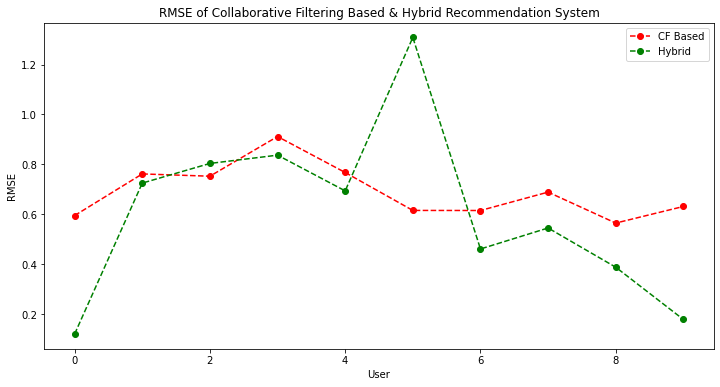

In [28]:
plt.plot(cf_rmse_val, 'ro--', label='CF Based')
plt.plot(hybrid_rmse_val, 'go--', label='Hybrid')
plt.xlabel('User')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('hybrid_cf_rmse.png', dpi=100)
plt.show()

### The average RMSE plot also shows the superiority of hybrid system.

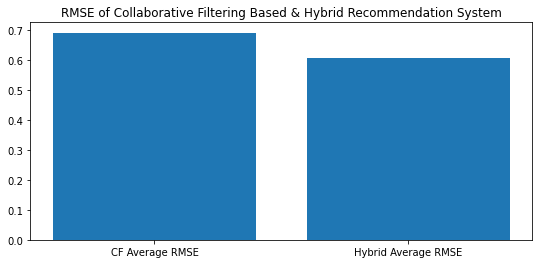

In [29]:
plt.bar(['CF Average RMSE','Hybrid Average RMSE'],[cf_avg_rmse,hybrid_avg_rmse])
plt.title('RMSE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(9, 4)
fig.savefig('hybrid_cf_rmse_avg.png', dpi=100)
plt.show()

### Here we choose top recommended movies by both system for 10 users & calculate MAE errors for each system for comaprison. 

In [30]:
mae_val_sum=0
mae_count=0
hybrid_mae_val=[]
            
def mae(predictions, targets):
    return (abs(predictions - targets).mean())

# random.seed(100)
# random_users = random.sample(range(6040), 10)

# for j in random_users: 
for j in range(20): 
    x=hybrid_recommendations(j, 'Toy Story (1995)')
    rating_sum=0
    count=0
    y_actual=[]
    y_pred=[]
    for i in range(len(x)):
        if x.iloc[i]['actual_rating'].size>0:
            y_actual.append((int(x.iloc[i]['actual_rating'])))
            y_pred.append((x.iloc[i]['estimated_rating']))

    mae_val = mae(np.array(y_pred), np.array(y_actual))
    
    y = float(mae_val)
    if math.isnan(y)==False:
        hybrid_mae_val.append(mae_val)
        mae_val_sum=mae_val_sum+mae_val
        mae_count=mae_count+1 
    if mae_count==10:
        break
    
hybrid_avg_mae=mae_val_sum/mae_count
print("Average MAE for hybrid system:",hybrid_avg_mae)

Average MAE for hybrid system: 0.5411250675947068


In [31]:
mae_val_sum=0
mae_count=0
cf_mae_val=[]

def mae(predictions, targets):
    return (abs(predictions - targets).mean())

# random.seed(0)
# random_users = random.sample(range(6040), 10)

# for j in random_users: 
for j in range(20): 
    x=cf_top_reco(j)
    rating_sum=0
    count=0
    y_actual=[]
    y_pred=[]
    for i in range(len(x)):
        if x.iloc[i]['actual_rating'].size>0:
            y_actual.append((int(x.iloc[i]['actual_rating'])))
            y_pred.append((x.iloc[i]['estimated_rating']))

    mae_val = mae(np.array(y_pred), np.array(y_actual))
    
    y = float(mae_val)
    if math.isnan(y)==False:
        cf_mae_val.append(mae_val)
        mae_val_sum=mae_val_sum+mae_val
        mae_count=mae_count+1 
    if mae_count==10:
        break
    
cf_avg_mae=mae_val_sum/mae_count
print("Average MAE for collaborative filtering based system:",cf_avg_mae)

Average MAE for collaborative filtering based system: 0.549342147251646


### From the MAE plot for 10 users we see that hybrid system has comparatively lower MAE overall.

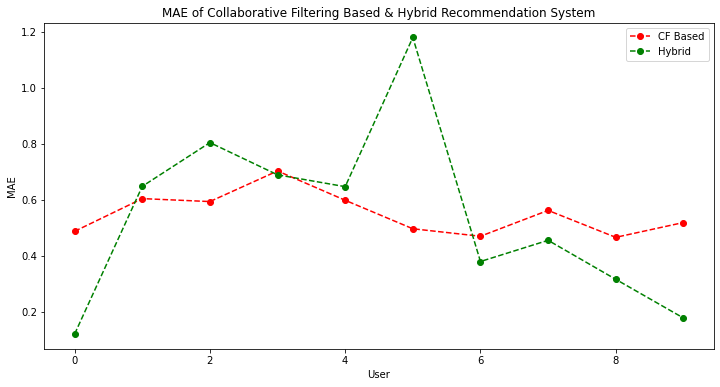

In [32]:
plt.plot(cf_mae_val, 'ro--', label='CF Based')
plt.plot(hybrid_mae_val, 'go--', label='Hybrid')
plt.xlabel('User')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('hybrid_cf_mae.png', dpi=100)
plt.show()

### The average MAE plot also shows the superiority of hybrid system.

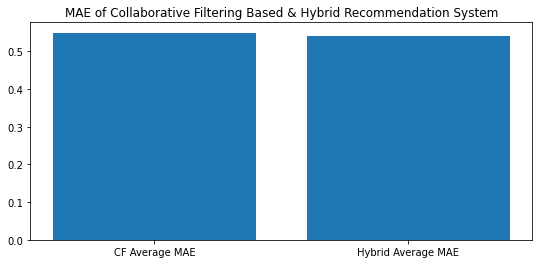

In [33]:
plt.bar(['CF Average MAE','Hybrid Average MAE'],[cf_avg_mae,hybrid_avg_mae])
plt.title('MAE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(9, 4)
fig.savefig('hybrid_cf_mae_avg.png', dpi=100)
plt.show()

### Let's consider 5 set of users with a batch size of 5 for whom we want to do the same test

### RMSE

In [34]:
all_hybrid_avg_rmse=[]  
for k in range(5):
    rmse_val_sum=0
    rmse_count=0
    hybrid_rmse_val=[]

    def rmse(predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())
    
#     random.seed(k)
#     random_users = random.sample(range(6040), 20)

    first=k*10

    for j in range(first,first+10): 
        x=hybrid_recommendations(j, 'Toy Story (1995)')
        rating_sum=0
        count=0
        y_actual=[]
        y_pred=[]
        for i in range(len(x)):
            if x.iloc[i]['actual_rating'].size>0:
                y_actual.append((int(x.iloc[i]['actual_rating'])))
                y_pred.append((x.iloc[i]['estimated_rating']))

        rmse_val = rmse(np.array(y_pred), np.array(y_actual))

        y = float(rmse_val)
        if math.isnan(y)==False:
            hybrid_rmse_val.append(rmse_val)
            rmse_val_sum=rmse_val_sum+rmse_val
            rmse_count=rmse_count+1 
        if rmse_count==5:
            break

    hybrid_avg_rmse=rmse_val_sum/rmse_count
    print("Average RMSE for hybrid system:",hybrid_avg_rmse)
    all_hybrid_avg_rmse.append(hybrid_avg_rmse)

all_hybrid_avg_rmse_one=sum(all_hybrid_avg_rmse)/len(all_hybrid_avg_rmse)

Average RMSE for hybrid system: 0.6361329841124497
Average RMSE for hybrid system: 0.4874612959769692
Average RMSE for hybrid system: 0.6529221699598681
Average RMSE for hybrid system: 0.8483245964924103
Average RMSE for hybrid system: 0.8114489479918167


In [35]:
all_cf_avg_rmse=[]  
for k in range(5):
    rmse_val_sum=0
    rmse_count=0
    cf_rmse_val=[]

    def rmse(predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())

#     random.seed(k)
#     random_users = random.sample(range(6040), 20)

    first=k*10

    for j in range(first,first+10): 
        x=cf_top_reco(j)
        rating_sum=0
        count=0
        y_actual=[]
        y_pred=[]
        for i in range(len(x)):
            if x.iloc[i]['actual_rating'].size>0:
                y_actual.append((int(x.iloc[i]['actual_rating'])))
                y_pred.append((x.iloc[i]['estimated_rating']))

        rmse_val = rmse(np.array(y_pred), np.array(y_actual))

        y = float(rmse_val)
        if math.isnan(y)==False:
            cf_rmse_val.append(rmse_val)
            rmse_val_sum=rmse_val_sum+rmse_val
            rmse_count=rmse_count+1 
        if rmse_count==5:
            break
            
    cf_avg_rmse=rmse_val_sum/rmse_count
    print("Average RMSE for collaborative filtering based system:",cf_avg_rmse)
    all_cf_avg_rmse.append(cf_avg_rmse)
    
all_cf_avg_rmse_one=sum(all_cf_avg_rmse)/len(all_cf_avg_rmse)

Average RMSE for collaborative filtering based system: 0.7578005525274311
Average RMSE for collaborative filtering based system: 0.7845304886019784
Average RMSE for collaborative filtering based system: 0.7548411060634652
Average RMSE for collaborative filtering based system: 0.7528667048709206
Average RMSE for collaborative filtering based system: 0.765037472949931


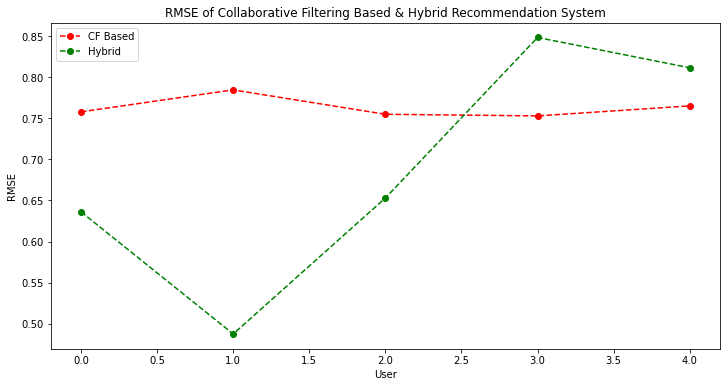

In [36]:
plt.plot(all_cf_avg_rmse, 'ro--', label='CF Based')
plt.plot(all_hybrid_avg_rmse, 'go--', label='Hybrid')
plt.xlabel('User')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('all_hybrid_cf_rmse.png', dpi=100)
plt.show()

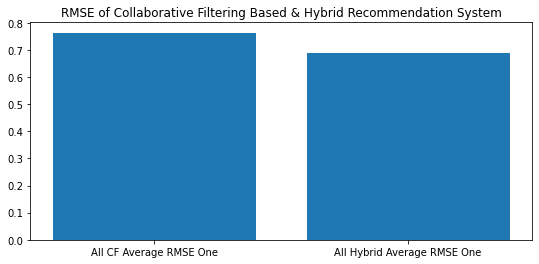

In [37]:
plt.bar(['All CF Average RMSE One','All Hybrid Average RMSE One'],[all_cf_avg_rmse_one,all_hybrid_avg_rmse_one])
plt.title('RMSE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(9, 4)
fig.savefig('hybrid_cf_rmse_avg_one.png', dpi=100)
plt.show()

### MAE

In [38]:
all_hybrid_avg_mae=[]  
for k in range(5):
    mae_val_sum=0
    mae_count=0
    hybrid_mae_val=[]

    def mae(predictions, targets):
        return (abs(predictions - targets).mean())

#     random.seed(k)
#     random_users = random.sample(range(6040), 20)

    first=k*10

    for j in range(first,first+10): 
        x=hybrid_recommendations(j, 'Toy Story (1995)')
        rating_sum=0
        count=0
        y_actual=[]
        y_pred=[]
        for i in range(len(x)):
            if x.iloc[i]['actual_rating'].size>0:
                y_actual.append((int(x.iloc[i]['actual_rating'])))
                y_pred.append((x.iloc[i]['estimated_rating']))

        mae_val = mae(np.array(y_pred), np.array(y_actual))

        y = float(mae_val)
        if math.isnan(y)==False:
            hybrid_mae_val.append(mae_val)
            mae_val_sum=mae_val_sum+mae_val
            mae_count=mae_count+1 
        if mae_count==5:
            break

    hybrid_avg_mae=mae_val_sum/mae_count
    print("Average MAE for hybrid system:",hybrid_avg_mae)
    all_hybrid_avg_mae.append(hybrid_avg_mae)
    
all_hybrid_avg_mae_one=sum(all_hybrid_avg_mae)/len(all_hybrid_avg_rmse)

Average MAE for hybrid system: 0.5812180228877859
Average MAE for hybrid system: 0.4306979207468922
Average MAE for hybrid system: 0.5640156875484849
Average MAE for hybrid system: 0.7546991413588445
Average MAE for hybrid system: 0.6878665792678589


In [39]:
all_cf_avg_mae=[]  
for k in range(5):
    mae_val_sum=0
    mae_count=0
    cf_mae_val=[]

    def mae(predictions, targets):
        return (abs(predictions - targets).mean())

#     random.seed(k)
#     random_users = random.sample(range(6040), 20)

    first=k*10

    for j in range(first,first+10): 
        x=cf_top_reco(j)
        rating_sum=0
        count=0
        y_actual=[]
        y_pred=[]
        for i in range(len(x)):
            if x.iloc[i]['actual_rating'].size>0:
                y_actual.append((int(x.iloc[i]['actual_rating'])))
                y_pred.append((x.iloc[i]['estimated_rating']))

        mae_val = mae(np.array(y_pred), np.array(y_actual))

        y = float(mae_val)
        if math.isnan(y)==False:
            cf_mae_val.append(mae_val)
            mae_val_sum=mae_val_sum+mae_val
            mae_count=mae_count+1 
        if mae_count==5:
            break

    cf_avg_mae=mae_val_sum/mae_count
    print("Average MAE for collaborative filtering based system:",cf_avg_mae)
    all_cf_avg_mae.append(cf_avg_mae)
    
all_cf_avg_mae_one=sum(all_cf_avg_mae)/len(all_cf_avg_mae)

Average MAE for collaborative filtering based system: 0.5967506177900737
Average MAE for collaborative filtering based system: 0.6391147417173487
Average MAE for collaborative filtering based system: 0.6019153732530131
Average MAE for collaborative filtering based system: 0.620688261759885
Average MAE for collaborative filtering based system: 0.639729864839251


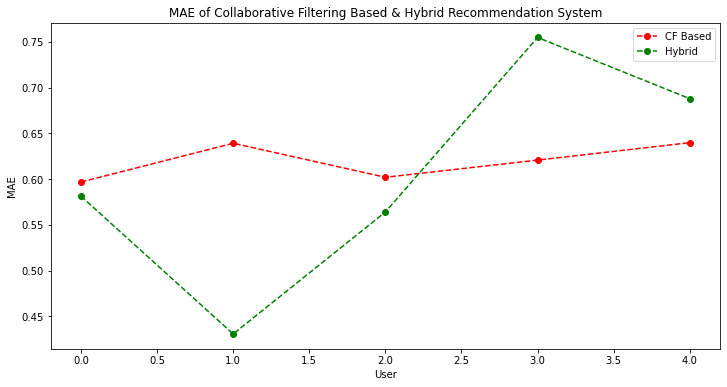

In [40]:
plt.plot(all_cf_avg_mae, 'ro--', label='CF Based')
plt.plot(all_hybrid_avg_mae, 'go--', label='Hybrid')
plt.xlabel('User')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('set_all_hybrid_cf_mae.png', dpi=100)
plt.show()

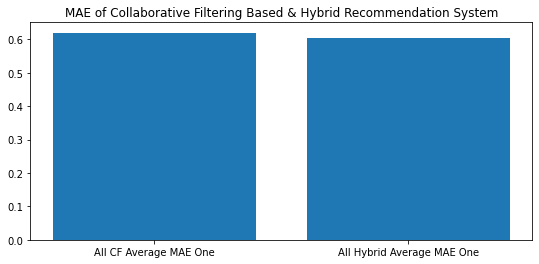

In [41]:
plt.bar(['All CF Average MAE One','All Hybrid Average MAE One'],[all_cf_avg_mae_one,all_hybrid_avg_mae_one])
plt.title('MAE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(9, 4)
fig.savefig('hybrid_cf_mae_avg_one.png', dpi=100)
plt.show()

### Here we have made a total of 4 different comparisons

### 1. We have compared the RMSE between Collaborative Filtering Based and Hybrid Recommendation System. Hybrid System clearly performed better with lower RMSE.
### 2. We have compared the MAE between Collaborative Filtering Based and Hybrid Recommendation System. Hybrid System clearly performed better with lower MAE.
### 3. Next we selected 5 sets of user groups where each group contains 5 users. We calculated the RMSE of these sets of users & the comparison shows Hybrid system performs better comparatively.
### 4. We did the same for MAE with 5 sets of user groups. Hybrid system came on top here too overall.

### Based on the above tests, we can conclude that Hybrid system shows better performance both qualitatively & quantitatively.  

# Hybrid Model Based on Emotional Information
### Detecting Emotion on the Face Using DeepFace Library

In [42]:
import cv2

## https://github.com/serengil/deepface
from deepface import DeepFace

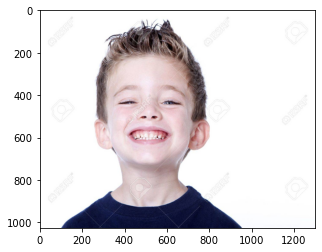

In [43]:
img = cv2.imread("happy_face.jpg")
plt.imshow(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [44]:
predictions = DeepFace.analyze(img, actions=["emotion"])

In [45]:
predictions

{'emotion': {'angry': 2.818526079195749e-07,
  'disgust': 6.169314072866335e-13,
  'fear': 2.984087976720673e-09,
  'happy': 100.0,
  'sad': 1.203729382837082e-06,
  'surprise': 2.5063227860298853e-11,
  'neutral': 2.3173731822367927e-07},
 'dominant_emotion': 'happy',
 'region': {'x': 243, 'y': 238, 'w': 536, 'h': 536}}

In [46]:
emotions = predictions["dominant_emotion"]
emotions

'happy'

In [47]:
# Real Time Face Emotion Detection

# import cv2;
# from deepface import DeepFace

# faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# cap = cv2.VideoCapture(1)

# if not cap.isOpened():
#     cap = cv2.VideoCapture(0)
# if not cap.isOpened():
#     raise IOError("Webcam is not opened..")
    
    
# while True:
#     ret, frame = cap.read()
#     result = DeepFace.analyze(frame, actions = ["emotion"])
    
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     faces = faceCascade.detectMultiScale(gray, 1.1, 4)
    
#     for(x, y, w, h) in faces:
#         cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 255, 0), 2)
        
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     cv2.putText(frame, result["dominant_emotion"], (50, 50), font, 3, (0, 0, 255), 2, cv2.LINE_4);
#     #print(result["dominant_emotion"]);
    
#     cv2.imshow('Testing video', frame)
    
#     if(cv2.waitKey(2) & 0xFF == ord('q')):
#         break

# cap.release()
# cv2.destroyAllWindows()

In [48]:
# emotions="Fear"

## Emotion associated with Genre of Movie
There are 7 classes of emotion that would be effective to classify a text. These are: 
1. Angry
2. Fear
3. Neutral
4. Sad
5. Disgust
6. Happy
7. Surprise

Here these are taken as input and the corresponding movies would be displayed for the emotion.
The correspondence of every emotion with genre of movies is listed below:

In [49]:
allgenres=['Action','Adventure','Animation',"Children's",'Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

In [61]:
allemotions=['angry','fear','neutral','sad','disgust','happy','surprise']
data=[[21.7,4.3,1.4,1.4,27.5,11.6,4.3,5.8,4.3,0.0,1.4,0.0,0.0,7.2,1.4,8.7,21.7,0.0],
[0.0,4.3,7.2,7.2,37.7,2.9,2.9,1.4,0.0,0.0,27.1,0.0,5.7,5.7,2.9,2.9,0.0,0.0],
[5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5],
[1.4,7.1,5.7,5.7,15.7,7.1,10.0,10.0,4.3,0.0,2.9,0.0,2.9,24.3,2.9,5.7,1.4,0.0],
[7.1,5.7,7.1,7.1,22.9,2.9,1.4,12.9,5.7,0.0,8.6,0.0,5.7,12.9,2.9,4.3,7.1,0.0],
[7.1,5.7,2.9,2.9,14.3,2.9,7.1,2.9,11.4,0.0,4.3,0.0,7.1,20.0,8.6,5.7,7.1,0.0],
[0.0,5.7,5.7,5.7,4.3,2.9,8.6,5.7,7.1,0.0,2.9,0.0,11.4,11.4,10.0,24.3,0.0,0.0]]
emotionGenreMat=pd.DataFrame(data,columns=allgenres,index=allemotions)
emotionGenreMat

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
angry,21.7,4.3,1.4,1.4,27.5,11.6,4.3,5.8,4.3,0.0,1.4,0.0,0.0,7.2,1.4,8.7,21.7,0.0
fear,0.0,4.3,7.2,7.2,37.7,2.9,2.9,1.4,0.0,0.0,27.1,0.0,5.7,5.7,2.9,2.9,0.0,0.0
neutral,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5
sad,1.4,7.1,5.7,5.7,15.7,7.1,10.0,10.0,4.3,0.0,2.9,0.0,2.9,24.3,2.9,5.7,1.4,0.0
disgust,7.1,5.7,7.1,7.1,22.9,2.9,1.4,12.9,5.7,0.0,8.6,0.0,5.7,12.9,2.9,4.3,7.1,0.0
happy,7.1,5.7,2.9,2.9,14.3,2.9,7.1,2.9,11.4,0.0,4.3,0.0,7.1,20.0,8.6,5.7,7.1,0.0
surprise,0.0,5.7,5.7,5.7,4.3,2.9,8.6,5.7,7.1,0.0,2.9,0.0,11.4,11.4,10.0,24.3,0.0,0.0


In [51]:
# emotionToGenre={
#     'angry':['Action','Adventure','Animation','Comedy','Crime','Documentary','Drama','Family','Fantasy','Foreign','History','Horror','Music','Mystery','Romance','Science Fiction','TV Movie','Thriller','War','Western'],
#     'fear':['Action','Adventure','Animation','Comedy','Crime','Documentary','Drama','Family','Fantasy','Foreign','History','Horror','Music','Mystery','Romance','Science Fiction','TV Movie','Thriller','War','Western'],
#     'neutral':['Action','Adventure','Animation','Comedy','Crime','Documentary','Drama','Family','Fantasy','Foreign','History','Horror','Music','Mystery','Romance','Science Fiction','TV Movie','Thriller','War','Western'],
#     'sad':['Action','Adventure','Animation','Comedy','Crime','Documentary','Drama','Family','Fantasy','Foreign','History','Horror','Music','Mystery','Romance','Science Fiction','TV Movie','Thriller','War','Western'],
#     'disgust':['Action','Adventure','Animation','Comedy','Crime','Documentary','Drama','Family','Fantasy','Foreign','History','Horror','Music','Mystery','Romance','Science Fiction','TV Movie','Thriller','War','Western'],
#     'happy':['Action','Adventure', 'Animation','Comedy','Crime','Documentary','Drama','Family','Fantasy','Foreign','History','Horror','Music','Mystery','Romance','Science Fiction','TV Movie','Thriller','War','Western'],
#     'surprise':['Action','Adventure', 'Animation','Comedy','Crime','Documentary','Drama','Family','Fantasy','Foreign','History','Horror','Music','Mystery','Romance','Science Fiction','TV Movie','Thriller','War','Western']
# }

In [52]:
#InputFromRS=pd.read_csv('movies.csv')   #input from HRS
#InputFromRS = movies_1m[['Title','Genres']]
InputFromRS = recommendationsFromHybridSystem[['title', 'genres']]
InputFromRS.drop_duplicates(subset='title',keep='first',inplace=True)
print(InputFromRS)

                                            title  \
2      American Tail: Fievel Goes West, An (1991)   
3                       Rugrats Movie, The (1998)   
0          Aladdin and the King of Thieves (1996)   
8  Adventures of Rocky and Bullwinkle, The (2000)   
7                              Chicken Run (2000)   
6                           Saludos Amigos (1943)   
5                              Toy Story 2 (1999)   
1                        American Tail, An (1986)   
4                            Bug's Life, A (1998)   
9                           Goofy Movie, A (1995)   

                                              genres  
2            [['Animation', "Children's", 'Comedy']]  
3            [['Animation', "Children's", 'Comedy']]  
0            [['Animation', "Children's", 'Comedy']]  
8            [['Animation', "Children's", 'Comedy']]  
7            [['Animation', "Children's", 'Comedy']]  
6            [['Animation', "Children's", 'Comedy']]  
5            [['Animation', "Ch

In [53]:
InputFromRS_df = pd.DataFrame({'title': InputFromRS['title'], 'genres': InputFromRS['genres']})
InputFromRS_df

,title,genres
2,"American Tail: Fievel Goes West, An (1991)","[['Animation', ""Children's"", 'Comedy']]"
3,"Rugrats Movie, The (1998)","[['Animation', ""Children's"", 'Comedy']]"
0,Aladdin and the King of Thieves (1996),"[['Animation', ""Children's"", 'Comedy']]"
8,"Adventures of Rocky and Bullwinkle, The (2000)","[['Animation', ""Children's"", 'Comedy']]"
7,Chicken Run (2000),"[['Animation', ""Children's"", 'Comedy']]"
6,Saludos Amigos (1943),"[['Animation', ""Children's"", 'Comedy']]"
5,Toy Story 2 (1999),"[['Animation', ""Children's"", 'Comedy']]"
1,"American Tail, An (1986)","[['Animation', ""Children's"", 'Comedy']]"
4,"Bug's Life, A (1998)","[['Animation', ""Children's"", 'Comedy']]"
9,"Goofy Movie, A (1995)","[['Animation', ""Children's"", 'Comedy', 'Romanc..."


In [54]:
print(InputFromRS_df['genres'][0])

['[\'Animation\', "Children\'s", \'Comedy\']']


In [55]:
# genreListAccToEmotion=pd.DataFrame({'genres': emotionToGenre[emotion]})     #input from emotion dictionatry
# genreListAccToEmotion.sort()
# genreListAccToEmotion
#genreListAccToEmotion['genres']
# emoGen = emotionToGenre[emotion]
# emoGen

In [56]:
# temp = temp.set_index('genres')
# temp = temp.reindex(index=genreListAccToEmotion['genres'])
# temp = temp.reset_index()

In [57]:
# import jellyfish

In [58]:
# for i in range(10):
#     jellyfish.jaro_distance(InputFromRS_df['genres'][i], emoGen)
#     print(InputFromRS_df['genres'][i]) # and emoGen

In [62]:
def emo_hybrid(emotions,InputFromRS_df,emotionGenreMat):
    list=[]
    for val in InputFromRS['genres']:
        str1=val[0]
        genres_list=eval(str1)
#     genres=['Action','Comedy','Animation']
        sim_score=0
        for i in genres_list:
            sim_score+=emotionGenreMat.at[emotions,i]
        list.append(sim_score)
    InputFromRS_df['sim'] = list
    InputFromRS_df.sort_values(['sim'],ascending=False,inplace=True)
    return InputFromRS_df.head(50)

In [63]:
emo_hybrid(emotions,InputFromRS_df,emotionGenreMat)

,title,genres,sim
9,"Goofy Movie, A (1995)","[['Animation', ""Children's"", 'Comedy', 'Romanc...",40.1
2,"American Tail: Fievel Goes West, An (1991)","[['Animation', ""Children's"", 'Comedy']]",20.1
3,"Rugrats Movie, The (1998)","[['Animation', ""Children's"", 'Comedy']]",20.1
0,Aladdin and the King of Thieves (1996),"[['Animation', ""Children's"", 'Comedy']]",20.1
8,"Adventures of Rocky and Bullwinkle, The (2000)","[['Animation', ""Children's"", 'Comedy']]",20.1
7,Chicken Run (2000),"[['Animation', ""Children's"", 'Comedy']]",20.1
6,Saludos Amigos (1943),"[['Animation', ""Children's"", 'Comedy']]",20.1
5,Toy Story 2 (1999),"[['Animation', ""Children's"", 'Comedy']]",20.1
1,"American Tail, An (1986)","[['Animation', ""Children's"", 'Comedy']]",20.1
4,"Bug's Life, A (1998)","[['Animation', ""Children's"", 'Comedy']]",20.1
